## Machine Learning Foundation & Techniques: Assignment 7

### Unpruned Decision Tree
---
Implement the simple C&RT algorithm without pruning using the Gini index as the impurity measure as introduced in the class. For the decision stump used in branching, if you are branching with feature $i$ and direction $s$, please sort all the $x_{n,i}$ values to form (at most) $N + 1$ segments of equivalent $\theta$, and then pick $\theta$ within the median of the segment.

Run the algorithm on the following set for training:
          http://www.csie.ntu.edu.tw/~htlin/course/ml15fall/hw7/hw7_train.dat

and the following set for testing:
          http://www.csie.ntu.edu.tw/~htlin/course/ml15fall/hw7/hw7_test.dat


In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

def generate_data(file):
    """Return data point X and lable Y."""
    data = pd.read_csv(file, sep=' ', header=None)
    X = data.loc[:, 0:1]
    Y = np.array(data.loc[:, 2:]).flatten()
    
    return X, Y

##### Build decision tree model

In [2]:
class DecisionTree:
    """ Unprunded decision tree by simple C&RT algorithm using Gini index as impurity measure.
        Pruned version can be made by setting maximum height parameter.
    """
    
    # --------------------- Internal Node Class --------------------- #
    class Node:
        """Internal node class to store information in each node."""
        
        def __init__(self, height, position, branch=None, value=None):
            self.height = height
            self.position = position
            self.branch = branch
            self.value = value
    
    
    # --------------------- Binary Decision Tree Constructor --------------------- #
    def __init__(self, print_flag=False):
        """Create an empty binary tree."""
        
        self.dim = None                # dimension of the data
        self.size = 0                  # total size of the tree
        self.node_dict = {}            # internal node dictionary
        self.print_flag = print_flag
   
    
    def construct_tree(self, data, col_y, height=0, position=0, max_height=50):      
        """Construct decision tree by recursively branching each node."""
        
        self.dim = data.shape[1]
        y = col_y  # y column name
        
        # return empty tree if no data
        if (data.shape[0] == 0): return;
        
        # printing training information if set to True
        if self.print_flag:
            if position == 0: print('Start training decision tree.')
        
        # terminate when no branch can be made (all y are the same)
        if len(pd.unique(data.y)) == 1:
            value = pd.unique(data.y)[0]
            self.node_dict[position] = self.Node(height, position, value=value)
            self.size += 1
        # terminate when height reaches the maximum limit
        elif height >= max_height:
            value = 2 * (np.sum(data.y.values) >= 0) - 1
            self.node_dict[position] = self.Node(height, position, value=value)
        # recursvively branching each node
        else:
            b = self.branching(data)
            self.node_dict[position] = self.Node(height, position, b)
            best_dim, best_theta = b
            self.size += 1
            
            # Construct left sub-tree
            LeftTree = data[data[best_dim] < best_theta]
            self.construct_tree(LeftTree, y, height + 1, 2 * position + 1, max_height)
            
            if self.print_flag:
                print('  ... constructing height %d left substree at position %d' %(height+1, 2*position+1))
            
            # Construct right sub-tree
            RightTree = data[data[best_dim] >= best_theta]
            self.construct_tree(RightTree, y, height + 1, 2 * position + 2, max_height)
            
            if self.print_flag:
                print('  ... constructing height %d right substree at position %d' %(height+1, 2*position+2))
            

    def branching(self, data):
        """ Use decision stump to find the best branching criteria
            Return the best threshold of i-th feature column.
        """
        
        N = data.shape[0]

        # Learn branching criteria b(X)
        min_impurity = 1
        for i in range(self.dim - 1):
            x = np.array(data.sort_values(i)[i])
            y = np.array(data.sort_values(i).y)
            thresholds = [(x[k] + x[k + 1]) / 2 for k in range(len(x) - 1)] + [np.max(x) + 1]
            for j in range(len(thresholds)):
                theta = thresholds[j]
                y1 = y[:j + 1]
                y2 = y[j + 1:]
                weighted_impurity = (len(y1) / N) * self.gini_index(y1) + (len(y2) / N) * self.gini_index(y2)

                if weighted_impurity <= min_impurity:
                    best_dim, best_theta, min_impurity = i, theta, weighted_impurity

        return best_dim, best_theta
            
    
    def gini_index(self, y):
        """Gini index for impurity measure"""
        
        if (len(y) == 0): return 0
        gini = 1.0
        for k in [1.0, -1.0]:
            gini -= np.square(np.sum(y == k) / len(y))

        return gini

    
    def predict(self, x, position = 0):
        """Predict the value of one data point x, recrusively traverse each node."""
        
        node = self.node_dict[position]
        
        if node.branch:
            branch_dim, branch_theta = node.branch
            if x[branch_dim] >= branch_theta:
                return self.predict(x, position = (2 * position + 2))
            else:
                return self.predict(x, position = (2 * position + 1))
        else:
            return node.value
        

##### Training model

In [3]:
train_file = 'data/hw7_train.dat.txt'; test_file = 'data/hw7_test.dat.txt'
data_train = pd.read_csv(train_file, sep = ' ', header = None, names=[0, 1, 'y'])
data_test = pd.read_csv(test_file, sep = ' ', header = None, names=[0, 1, 'y'])
X_train, Y_train = generate_data(train_file); X_test, Y_test = generate_data(test_file)

In [4]:
col_y = 'y'

time_start = time.clock()
Tree = DecisionTree(print_flag = True)
Tree.construct_tree(data_train, col_y)

print("Using %.3f seconds" % (time.clock() - time_start))

Start training decision tree.
  ... constructing height 3 left substree at position 7
  ... constructing height 3 right substree at position 8
  ... constructing height 2 left substree at position 3
  ... constructing height 5 left substree at position 39
  ... constructing height 5 right substree at position 40
  ... constructing height 4 left substree at position 19
  ... constructing height 5 left substree at position 41
  ... constructing height 5 right substree at position 42
  ... constructing height 4 right substree at position 20
  ... constructing height 3 left substree at position 9
  ... constructing height 5 left substree at position 43
  ... constructing height 5 right substree at position 44
  ... constructing height 4 left substree at position 21
  ... constructing height 4 right substree at position 22
  ... constructing height 3 right substree at position 10
  ... constructing height 2 right substree at position 4
  ... constructing height 1 left substree at position 1

#### 13. Draw the resulting tree

In [5]:
print('=============== Result for one fully grown decision tree ===============')
for key in sorted(Tree.node_dict.keys()):
    node = Tree.node_dict[key]
    print(' height: %d; position: %d; branch: %s; value: %s' %(node.height, node.position, node.branch, node.value))

=============== Result for one fully grown decision tree ===============
 height: 0; position: 0; branch: (1, 0.62623300000000004); value: None
 height: 1; position: 1; branch: (0, 0.22443950000000001); value: None
 height: 1; position: 2; branch: (0, 0.8781715000000001); value: None
 height: 2; position: 3; branch: (1, 0.11515275); value: None
 height: 2; position: 4; branch: (0, 0.54150799999999999); value: None
 height: 2; position: 5; branch: None; value: -1
 height: 2; position: 6; branch: None; value: 1
 height: 3; position: 7; branch: None; value: 1
 height: 3; position: 8; branch: None; value: -1
 height: 3; position: 9; branch: (1, 0.35862050000000001); value: None
 height: 3; position: 10; branch: (1, 0.28592499999999998); value: None
 height: 4; position: 19; branch: (0, 0.50162499999999999); value: None
 height: 4; position: 20; branch: (0, 0.26075149999999997); value: None
 height: 4; position: 21; branch: (1, 0.26603849999999996); value: None
 height: 4; position: 22; bra

#### 14. Continuing from Question 13, what is the $E_{in}$ of the tree?
#### 15. Continuing from Question 13, what is the $E_{out}$ of the tree?

In [6]:
print('--- Decision tree model accuracy ---')
Y_train_pred = [Tree.predict(x) for x in np.array(X_train)]
train_acc = np.sum(Y_train_pred == Y_train) / len(Y_train) * 100
print('Accuracy on the training set: %.2f %%' %train_acc)

Y_test_pred = [Tree.predict(x) for x in np.array(X_test)]
test_acc = np.sum(Y_test_pred == Y_test) / len(Y_test) * 100
print('Accuracy on the testing set: %.2f %%' %test_acc)

--- Decision tree model accuracy ---
Accuracy on the training set: 100.00 %
Accuracy on the testing set: 87.40 %


### Random Forest
---
Now implement the Bagging algorithm with $N' = N$ and couple it with your decision tree above to make a preliminary random forest $G_{RF}$ . Produce $T = 30000$ trees with bagging. Compute $E_{in}$ and $E_{out}$ using the 0/1 error.

##### Build random forest model

In [7]:
class RandomForest:
    """Random forest using C&RT decision tree."""
    
    def __init__(self):
        self.tree_dict = {}     # internal tree dictionary 
    
    
    def construct_forest(self, data, col_y, size, max_height = 50):
        """Construct random forest by bagging from the original dataset."""
        
        self.N = data.shape[0]
        self.max_height = max_height
        
        print('Start training random forest')
        for i in range(size):
            resample_data = self.bagging(data, self.N)
            Tree = DecisionTree()
            Tree.construct_tree(resample_data, col_y, max_height = self.max_height)
            self.tree_dict[i] = Tree  
            
            if i % 1000 == 999:
                print('  ... training %d-th decision tree' %(i + 1))
                
        print('----------      END      -----------')
    
    
    def bagging(self, data, N):
        """Resample from the original dataset."""
        return data.sample(N, replace = True)
    
    
    def predict(self, x, tree_size=None):
        """ Predict the value of one data point x by uniform voting from all decision trees.
            Predict value using the first t trees can be done by setting tree size parameter.
        """

        if tree_size:
            vote = [self.tree_dict[i].predict(x) for i in range(tree_size)]
        else:
            vote = [Tree.predict(x) for Tree in self.tree_dict.values()]
        return 1 if np.sum(vote) >= 0 else -1

##### Training model

In [9]:
col_y = 'y'
T = 30000

time_start = time.clock()
RF = RandomForest()
RF.construct_forest(data_train, col_y, size = T)

print("\nUsing %.3f seconds" % (time.clock() - time_start))

Start training random forest
  ... training 1000-th decision tree
  ... training 2000-th decision tree
  ... training 3000-th decision tree
  ... training 4000-th decision tree
  ... training 5000-th decision tree
  ... training 6000-th decision tree
  ... training 7000-th decision tree
  ... training 8000-th decision tree
  ... training 9000-th decision tree
  ... training 10000-th decision tree
  ... training 11000-th decision tree
  ... training 12000-th decision tree
  ... training 13000-th decision tree
  ... training 14000-th decision tree
  ... training 15000-th decision tree
  ... training 16000-th decision tree
  ... training 17000-th decision tree
  ... training 18000-th decision tree
  ... training 19000-th decision tree
  ... training 20000-th decision tree
  ... training 21000-th decision tree
  ... training 22000-th decision tree
  ... training 23000-th decision tree
  ... training 24000-th decision tree
  ... training 25000-th decision tree
  ... training 26000-th decisi

In [10]:
print('--- Random forest model accuarcy ---')
print('Start predicting model...\n')
time_start = time.clock()

Y_train_pred = [RF.predict(x) for x in np.array(X_train)]
train_acc = np.sum(Y_train_pred == Y_train) / len(Y_train) * 100
print('Accuracy on the training set: %.2f %%' %train_acc)
print("Using %.3f seconds to predict\n" % (time.clock() - time_start))

time_start = time.clock()
Y_test_pred = [RF.predict(x) for x in np.array(X_test)]
test_acc = np.sum(Y_test_pred == Y_test) / len(Y_test) * 100
print('Accuracy on the testing set: %.2f %%' %test_acc)
print("Using %.3f seconds to predict\n" % (time.clock() - time_start))

--- Random forest model accuarcy ---
Start predicting model...

Accuracy on the training set: 100.00 %
Using 13.625 seconds to predict

Accuracy on the testing set: 92.50 %
Using 139.201 seconds to predict



#### 16. Plot a histogram of $E_{in}(g_t)$ over the 30000 trees.

Computing training error for each tree
  ... computing error for 5000-th tree
  ... computing error for 10000-th tree
  ... computing error for 15000-th tree
  ... computing error for 20000-th tree
  ... computing error for 25000-th tree
  ... computing error for 30000-th tree

Using 11.851 seconds


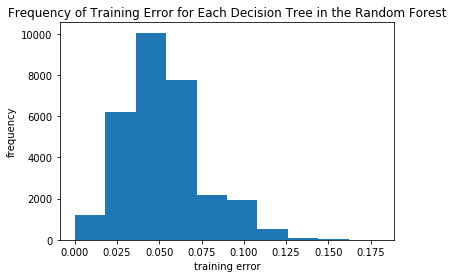

In [11]:
print('Computing training error for each tree')
time_start = time.clock()

err_in_g = []
for i in RF.tree_dict.keys():
    if i % 5000 == 4999: print('  ... computing error for %d-th tree' %(i + 1))
    
    Tree = RF.tree_dict[i]
    Y_train_pred = [Tree.predict(x) for x in np.array(X_train)]
    train_err = np.sum(Y_train_pred != Y_train) / len(Y_train)
    err_in_g.append(train_err)

print("\nUsing %.3f seconds" % (time.clock() - time_start))

plt.hist(err_in_g)
plt.xlabel('training error')
plt.ylabel('frequency')
plt.title('Frequency of Training Error for Each Decision Tree in the Random Forest')

#### 17. Let $G_t$ = “the random forest with the first t trees”. Plot a curve of $t$ versus $E_{in}(G_t)$.

In [120]:
def compute_forest_error(RF, T, X, Y):
    
    print('Start Computing error for each forest ...')
    time_start = time.clock()

    # record prediction from all trees
    pred_tree_all = []

    for i in range(T):  
        if i % 5000 == 4999: print('  ... computing prediction from %d-th tree' %(i + 1))

        Tree = RF.tree_dict[i]
        pred_tree = [Tree.predict(x) for x in np.array(X)]      # prediction for all y from one tree
        pred_tree_all.append(pred_tree)

    votes = np.cumsum(pred_tree_all, axis=0)

    err_list = []
    for t in range(T):
        vote = votes[t]
        vote[vote >= 0] = 1; vote[vote < 0] = -1

        err = np.sum(vote != Y) / len(Y)
        err_list.append(err)

    print("\nUsing %.3f seconds" % (time.clock() - time_start))
    
    return err_list

Start Computing error for each forest

Using 0.254 seconds


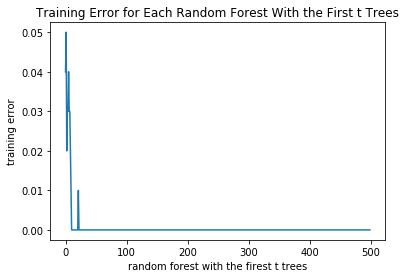

In [112]:
T = 1000
err_in_G = compute_forest_error(RF, T, X_train, Y_train)

plt.plot(err_in_G)
plt.xlabel('random forest with the firest t trees')
plt.ylabel('training error')
plt.title('Training Error for Each Random Forest With the First t Trees')

#### 18. Continuing from Question 17, and plot a curve of $t$ versus $E_{out}(G_t)$. Briefly compare with the curve in Question 17 and state your findings.

Start Computing error for each forest ...
  ... computing prediction from 5000-th tree
  ... computing prediction from 10000-th tree

Using 38.950 seconds


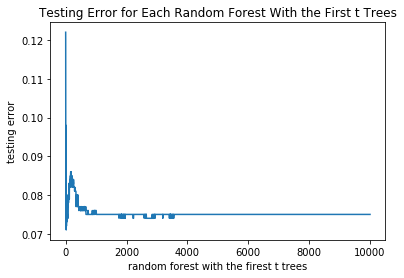

In [118]:
T = 10000

err_out_G = compute_forest_error(RF, T, X_test, Y_test)

plt.plot(err_out_G)
plt.xlabel('random forest with the firest t trees')
plt.ylabel('testing error')
plt.title('Testing Error for Each Random Forest With the First t Trees')

### Pruned Random Forest
---
Now, **‘prune’** your decision tree algorithm by restricting it to have one branch only. That is, the tree is simply a decision stump determined by Gini index. Make a random ‘forest’ $G_{RS}$ with those decision stumps with Bagging like Questions 16-18 with $T = 30000$. Compute $E_{in}$ and $E_{out}$ using the 0/1 error.

##### Training model

In [13]:
col_y = 'y'
T = 30000; max_height = 1

time_start = time.clock()
RF_Prune = RandomForest()
RF_Prune.construct_forest(data_train, col_y, size = T, max_height = max_height)

print("\nUsing %.3f seconds" % (time.clock() - time_start))

Start training random forest
  ... training 1000-th decision tree
  ... training 2000-th decision tree
  ... training 3000-th decision tree
  ... training 4000-th decision tree
  ... training 5000-th decision tree
  ... training 6000-th decision tree
  ... training 7000-th decision tree
  ... training 8000-th decision tree
  ... training 9000-th decision tree
  ... training 10000-th decision tree
  ... training 11000-th decision tree
  ... training 12000-th decision tree
  ... training 13000-th decision tree
  ... training 14000-th decision tree
  ... training 15000-th decision tree
  ... training 16000-th decision tree
  ... training 17000-th decision tree
  ... training 18000-th decision tree
  ... training 19000-th decision tree
  ... training 20000-th decision tree
  ... training 21000-th decision tree
  ... training 22000-th decision tree
  ... training 23000-th decision tree
  ... training 24000-th decision tree
  ... training 25000-th decision tree
  ... training 26000-th decisi

In [14]:
print('--- Pruned Random forest model accuarcy ---')
print('Start predicting model...\n')
time_start = time.clock()

Y_train_pred = [RF_Prune.predict(x) for x in np.array(X_train)]
train_acc = np.sum(Y_train_pred == Y_train) / len(Y_train) * 100
print('Model accuracy on the training set: %.2f %%' %train_acc)
print("Using %.3f seconds to predict\n" % (time.clock() - time_start))

time_start = time.clock()
Y_test_pred = [RF_Prune.predict(x) for x in np.array(X_test)]
test_acc = np.sum(Y_test_pred == Y_test) / len(Y_test) * 100
print('Accuracy on the testing set: %.2f %%' %test_acc)
print("Using %.3f seconds to predict\n" % (time.clock() - time_start))

--- Pruned Random forest model accuarcy ---
Start predicting model...

Model accuracy on the training set: 90.00 %
Using 4.430 seconds to predict

Accuracy on the testing set: 85.30 %
Using 44.059 seconds to predict



#### 19. Again, let $G_t$ = “the random forest with the first t decision stumps”. Plot a curve of $t$ versus $E_{in}(G_t)$.

Start Computing error for each forest ...
  ... computing prediction from 5000-th tree
  ... computing prediction from 10000-th tree
  ... computing prediction from 15000-th tree
  ... computing prediction from 20000-th tree
  ... computing prediction from 25000-th tree
  ... computing prediction from 30000-th tree

Using 7.891 seconds


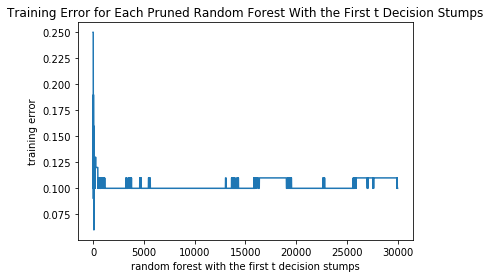

In [121]:
T = 30000

err_in_G = compute_forest_error(RF_Prune, T, X_train, Y_train)

plt.plot(err_in_G)
plt.xlabel('random forest with the first t decision stumps')
plt.ylabel('training error')
plt.title('Training Error for Each Pruned Random Forest With the First t Decision Stumps')

#### 20. Continuing from Question 19, and plot a curve of $t$ versus $E_{out}(G_t)$. Briefly compare with the curve in Question 19 and state your findings.

Start Computing error for each forest ...
  ... computing prediction from 5000-th tree
  ... computing prediction from 10000-th tree
  ... computing prediction from 15000-th tree
  ... computing prediction from 20000-th tree
  ... computing prediction from 25000-th tree
  ... computing prediction from 30000-th tree

Using 60.998 seconds


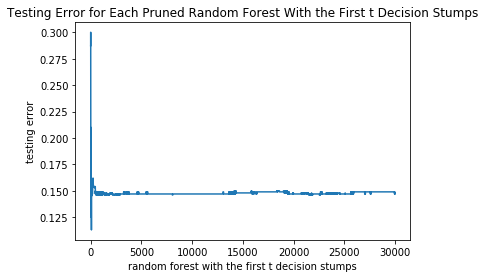

In [122]:
T = 30000

err_out_G = compute_forest_error(RF_Prune, T, X_test, Y_test)

plt.plot(err_out_G)
plt.xlabel('random forest with the first t decision stumps')
plt.ylabel('testing error')
plt.title('Testing Error for Each Pruned Random Forest With the First t Decision Stumps')